In [30]:
# ============================================================================
# CELLA 1: Estrazione dati e creazione DataFrame
# ============================================================================

import os
import glob
import numpy as np
import pandas as pd
from astropy.time import Time

# === CONFIGURAZIONE ===
INPUT_FOLDER = "../../../../../../../../Volumes/WD/MF/GRB/REM/GX/all/**/proc/"
REDUCED_FOLDER_NAME = "reduced"
TARGET_RA = 255.70578
TARGET_DEC = -48.78975
TOLERANCE_ARCSEC = 1.0
MAX_MAG_ERROR = 0.35
OUTPUT_CSV = "photometry_results.csv"

# === FUNZIONE ===
def parse_photometry_file(filepath, target_ra, target_dec, tolerance_arcsec, max_mag_error=0.35):
    result = {
        'filename': os.path.basename(filepath),
        'DATE_OBS': None, 'EXPTIME': None, 'Filter': None,
        'Zeropoint': None, 'ZP_err': None, 'RMS_quality': None,
        'ZP_check': None, 'Rejection_quality': None, 'Limiting_mag': None,
        'mag_cal': None, 'e_mag_cal': None, 'is_detection': False, 'separation_arcsec': None
    }
    
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
    except:
        return None
    
    for line in lines:
        if not line.startswith('#'):
            break
        if 'DATE-OBS:' in line:
            result['DATE_OBS'] = line.split('DATE-OBS:')[1].strip()
        elif 'EXPTIME:' in line:
            try: result['EXPTIME'] = float(line.split('EXPTIME:')[1].replace('s', '').strip())
            except: pass
        elif 'Filter:' in line:
            result['Filter'] = line.split('Filter:')[1].strip()
        elif 'Zeropoint:' in line and '+/-' in line:
            try:
                parts = line.split('Zeropoint:')[1].strip().split('+/-')
                result['Zeropoint'] = float(parts[0].strip())
                result['ZP_err'] = float(parts[1].replace('mag', '').strip())
            except: pass
        elif 'RMS quality:' in line:
            result['RMS_quality'] = line.split('RMS quality:')[1].strip()
        elif 'ZP_check:' in line:
            result['ZP_check'] = line.split('ZP_check:')[1].strip()
        elif 'Rejection quality:' in line:
            result['Rejection_quality'] = line.split('Rejection quality:')[1].strip()
        elif 'MagLim' in line:
            try: result['Limiting_mag'] = float(line.split(':')[1].replace('mag', '').strip())
            except: pass
    
    best_sep = float('inf')
    cos_dec = np.cos(np.radians(target_dec))
    
    for line in lines:
        if line.startswith('#'):
            continue
        parts = line.strip().split()
        if len(parts) >= 11:
            try:
                ra, dec = float(parts[0]), float(parts[1])
                sep = np.sqrt(((ra - target_ra) * cos_dec * 3600)**2 + ((dec - target_dec) * 3600)**2)
                if sep < tolerance_arcsec and sep < best_sep:
                    best_sep = sep
                    result['mag_cal'] = float(parts[8])
                    result['e_mag_cal'] = float(parts[9])
                    result['is_detection'] = True
                    result['separation_arcsec'] = sep
            except:
                continue
    
    if result['is_detection'] and result['e_mag_cal'] > max_mag_error:
        result['is_detection'] = False
        if result['Limiting_mag'] is not None:
            result['mag_cal'] = result['Limiting_mag']
            result['e_mag_cal'] = 0.0
    
    if not result['is_detection'] and result['Limiting_mag'] is not None:
        result['mag_cal'] = result['Limiting_mag']
        result['e_mag_cal'] = 0.0
    
    return result

# === ESTRAZIONE ===
print(f"Target: RA={TARGET_RA:.6f}, DEC={TARGET_DEC:.6f}, Tolerance={TOLERANCE_ARCSEC}\"")

phot_files = glob.glob(os.path.join(INPUT_FOLDER, '**', REDUCED_FOLDER_NAME, '*_photometry.txt'), recursive=True)
print(f"Trovati {len(phot_files)} file")

results = []
for filepath in phot_files:
    result = parse_photometry_file(filepath, TARGET_RA, TARGET_DEC, TOLERANCE_ARCSEC, MAX_MAG_ERROR)
    if result and result['DATE_OBS'] and result['mag_cal'] is not None:
        results.append(result)

# === CREA DATAFRAME ===
df = pd.DataFrame(results)

# Aggiungi colonne temporali utili
df['datetime'] = pd.to_datetime(df['DATE_OBS'])
df['MJD'] = df['DATE_OBS'].apply(lambda x: Time(x, format='isot').mjd if x else np.nan)
df['MJD_rel'] = df['MJD'] - df['MJD'].min()  # Giorni dal primo punto
df['hours_rel'] = df['MJD_rel'] * 24  # Ore dal primo punto

# Ordina per tempo
df = df.sort_values('MJD').reset_index(drop=True)

# Salva CSV
df.to_csv(OUTPUT_CSV, index=False)

# Summary
print(f"\nDetections: {df['is_detection'].sum()}, Upper limits: {(~df['is_detection']).sum()}")
print(f"Time range: MJD {df['MJD'].min():.4f} - {df['MJD'].max():.4f} ({df['MJD_rel'].max():.2f} days)")
print(f"Salvato: {OUTPUT_CSV}")

# Mostra DataFrame
display(df[['datetime', 'MJD', 'MJD_rel', 'Filter', 'mag_cal', 'e_mag_cal', 'is_detection', 'RMS_quality']])

Target: RA=255.705780, DEC=-48.789750, Tolerance=1.0"
Trovati 6437 file

Detections: 1568, Upper limits: 4869
Time range: MJD 59286.1553 - 59852.0174 (565.86 days)
Salvato: photometry_results.csv


,datetime,MJD,MJD_rel,Filter,mag_cal,e_mag_cal,is_detection,RMS_quality
0,2021-03-13 03:43:38.000,59286.155301,0.000000,K,11.0700,0.0000,False,MEDIUM
1,2021-03-13 03:44:01.000,59286.155567,0.000266,K,11.1100,0.0000,False,GOOD
2,2021-03-13 03:44:23.000,59286.155822,0.000521,K,11.3700,0.0000,False,MEDIUM
3,2021-03-13 03:44:50.000,59286.156134,0.000833,K,11.2738,0.2025,True,MEDIUM
4,2021-03-13 03:45:12.000,59286.156389,0.001088,K,11.4170,0.1771,True,MEDIUM
...,...,...,...,...,...,...,...,...
6432,2022-09-30 00:21:37.000,59852.015012,565.859711,J,13.3888,0.0507,True,MEDIUM
6433,2022-09-30 00:22:44.600,59852.015794,565.860493,J,13.1912,0.0202,True,MEDIUM
6434,2022-09-30 00:22:45.000,59852.015799,565.860498,J,13.1132,0.0386,True,GOOD
6435,2022-09-30 00:23:52.000,59852.016574,565.861273,J,13.1346,0.0401,True,MEDIUM


In [31]:
# ============================================================================
# CELLA 2: Filtri e Plot rapidi
# ============================================================================

import matplotlib.pyplot as plt

# === FILTRI RAPIDI (restituiscono subset del DataFrame) ===

def sel_filter(df, filt):
    """Seleziona per filtro: 'J', 'H', 'K'"""
    return df[df['Filter'] == filt]

def sel_detections(df):
    """Solo detection (no upper limits)"""
    return df[df['is_detection'] == True]

def sel_upperlimits(df):
    """Solo upper limits"""
    return df[df['is_detection'] == False]

def sel_quality(df, rms=None, rejection=None):
    """Filtra per qualità. Es: sel_quality(df, rms='GOOD', rejection='GOOD')"""
    mask = pd.Series([True] * len(df), index=df.index)
    if rms:
        mask &= df['RMS_quality'].str.upper() == rms.upper()
    if rejection:
        mask &= df['Rejection_quality'].str.upper() == rejection.upper()
    return df[mask]

def sel_coadd(df):
    """Solo coadd: ritorna righe il cui `filename` NON contiene 'aligned'."""
    return df[~df['filename'].str.contains('aligned', case=False, na=False)]

# === PLOT RAPIDO ===

def plot_lc(df, title='', color='blue', marker='o', label=None, ax=None, show_ul=True):
    """
    Plot curva di luce. Automaticamente separa detection e upper limits.
    
    Parametri:
    ----------
    df : DataFrame filtrato
    title : titolo del plot
    color : colore dei punti
    marker : marker per detection
    label : label per legenda
    ax : axis esistente (opzionale)
    show_ul : mostra upper limits come frecce
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))
    
    det = df[df['is_detection'] == True]
    ul = df[df['is_detection'] == False]
    
    # Plot detections
    if len(det) > 0:
        ax.errorbar(det['MJD_rel'], det['mag_cal'], yerr=det['e_mag_cal'],
                    fmt=marker, color=color, markersize=6, capsize=3,
                    linestyle='none', label=label or f'Det ({len(det)})')
    
    # Plot upper limits come frecce
    if show_ul and len(ul) > 0:
        ax.scatter(ul['MJD_rel'], ul['mag_cal'], marker='v', s=50,
                   facecolors='none', edgecolors=color, linewidths=1.5,
                   label=f'UL ({len(ul)})')
    
    ax.invert_yaxis()
    ax.set_xlabel('MJD - MJD$_0$ (days)')
    ax.set_ylabel('Magnitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

def plot_multifilter(df, filters=['J', 'H', 'K'], colors={'J': 'blue', 'H': 'green', 'K': 'red'}):
    """Plot multi-filtro in un unico grafico"""
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for filt in filters:
        sub = sel_filter(df, filt)
        if len(sub) > 0:
            plot_lc(sub, ax=ax, color=colors.get(filt, 'gray'), 
                    marker='o', label=f'{filt} ({len(sub)})')
    
    ax.set_title('Light Curve - All Filters')
    ax.legend()
    plt.tight_layout()
    plt.show()

# === ESEMPI DI USO ===
print("=== Esempi di uso ===")
print("sel_filter(df, 'K')              # solo banda K")
print("sel_detections(df)               # solo detection")
print("sel_upperlimits(df)              # solo upper limits")
print("sel_quality(df, rms='GOOD')      # solo RMS quality GOOD")
print("sel_quality(df, rejection='GOOD')# solo rejection quality GOOD")
print("")
print("# Combinazioni:")
print("sel_detections(sel_filter(df, 'K'))  # detection in K")
print("sel_quality(sel_filter(df, 'H'), rms='GOOD', rejection='GOOD')")
print("")
print("# Plot:")
print("plot_lc(sel_filter(df, 'K'), title='K-band')  # curva K")
print("plot_multifilter(df)                          # tutti i filtri")

=== Esempi di uso ===
sel_filter(df, 'K')              # solo banda K
sel_detections(df)               # solo detection
sel_upperlimits(df)              # solo upper limits
sel_quality(df, rms='GOOD')      # solo RMS quality GOOD
sel_quality(df, rejection='GOOD')# solo rejection quality GOOD

# Combinazioni:
sel_detections(sel_filter(df, 'K'))  # detection in K
sel_quality(sel_filter(df, 'H'), rms='GOOD', rejection='GOOD')

# Plot:
plot_lc(sel_filter(df, 'K'), title='K-band')  # curva K
plot_multifilter(df)                          # tutti i filtri


In [32]:
df_clean = sel_detections(sel_quality(df, rejection='GOOD'))

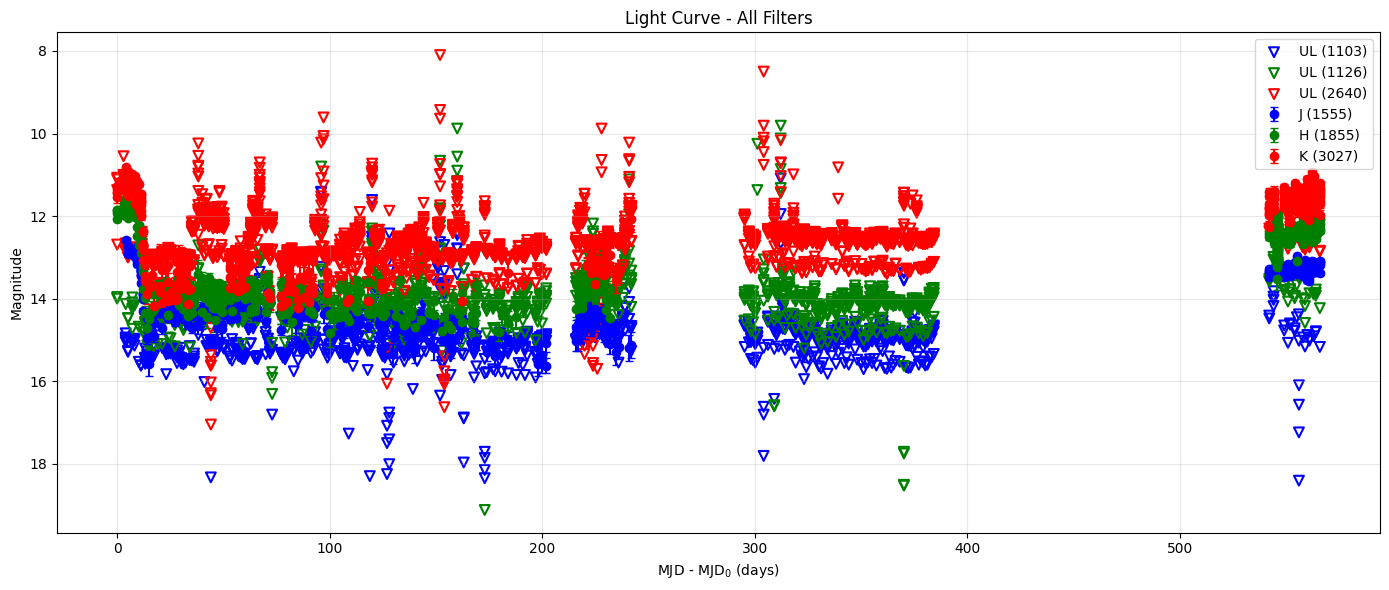

In [44]:
plot_multifilter(df)

In [45]:
1103+1555

2658

In [46]:
2640+3027

5667

In [36]:
n = df['is_detection'].nunique()

In [37]:
n

2

In [41]:
counts = df_coadd['is_detection'].value_counts()

In [42]:
counts

True     413
False     40
Name: is_detection, dtype: int64

In [40]:
is_detection

NameError: name 'is_detection' is not defined

In [43]:
40/(413+40)

0.08830022075055188